# Transitioning to `nengo_spa` coming from the core Nengo legacy SPA implementation

This tutorial is intended for persons who are already familiar with the legacy Semantic
Pointer Architecture (SPA) implementation that was shipped with core Nengo until at
least version 2.7. Thus, it will not explain any of the background behind the SPA and
will reference concepts used in the legacy implementation. If you are completely new to
the SPA, you might want to start with [this tutorial that assumes no knowledge of the
legacy SPA implementation](intro.ipynb).

## Why switch to `nengo_spa`?

You might wonder why you should switch to `nengo_spa`, if you have been using the legacy
SPA and it was working well for you. Here is a number of reasons to prefer `nengo_spa`:

### Support for action rules of arbitrary complexity

A rule as complex as `dot((role * filler + BiasVector) * tag, cmp) >> ...`, which
includes two circular convolutions and a dot product of two non-fixed values, is
possible with nengo_spa. This was not possible with the legacy SPA implementation.

### “Type safety” in action rules

If different vocabularies are combined an explicit conversion is required. This prevents
hard-to-track-down bugs. This conversion is also explicit about *how* the conversion is
done, instead of just applying a fixed method that is not always appropriate.


### The neural representations optimized for better accuracy

That means less neurons are needed to achieve the same performance. This can make
simulations run faster. This improvement of accuracy is comparable to the results
presented in [“Optimizing Semantic Pointer Representations for Symbol-Like Processing in
Spiking Neural
Networks”](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0149928)
which achieved improvements of up to 25 times. In contrast to that paper, the
implementation used in `nengo_spa` is purely based on setting appropriate radii and
distributions for evaluation points as well as intercepts. This implementation is much
faster.

### New Python-based syntax

A new Python-based syntax gives syntax highlighting and can make use of static checking
tools like pylint to catch misspelled names and similar errors early.

### Support for algebras
The SPA uses circular convolution for binding by default, but other binding operations
are also viable. Different [algebras](../user-guide/algebras.rst) can be implemented
with `nengo_spa`. In particular, an implementation of the [vector-derived transformation
binding
(VTB)](../modules/nengo_spa.algebras.rst#nengo_spa.algebras.vtb_algebra.VtbAlgebra) is
provided, which is especially suited for deep structures.

### Other features

* The neural representation has been optimized to allow the representation of the
identity vector (with the option to turn this optimization off).
* SPA networks can be used as and within normal Nengo networks. For example, instead of
a basic and an SPA associative memory network, there is only one type of network that
can be used in either case.
* SPA networks can be nested.
* Support for the Nengo config system.
* Scalars can now be routed and used as inputs/outputs using `spa.Scalar`.
* Lots of fixed issues and in general less possibilities to do things wrong.

## Importing nengo_spa

To save typing it is recommended to `import nengo_spa as spa`. Note that this is only a
very small difference to `import nengo.spa as spa` which imports the legacy SPA. In the
following, it is assumed that you imported `nengo_spa` as `spa`.

In [1]:
%matplotlib inline

import nengo
import numpy as np
import matplotlib.pyplot as plt

import nengo_spa as spa
from nengo_spa.examine import pairs
from nengo_spa.exceptions import SpaParseError, SpaTypeError

rng = np.random.RandomState(1)  # change this to change vocabularies

In [2]:
d = 32  # Default dimensionality to use in the examples

## Rule 1 of using nengo_spa

When using `nengo_spa`, use `spa.Network()` in any place where you would use a
`nengo.Network()`. There isn't any downside to using `spa.Network()` and in this way you
will not run into problems of using `nengo.Network()` where `spa.Network()` is required.
That being said, if you have existing `nengo.Network`s (that do not use any SPA
features), these can stay `nengo.Network`s. In other words, you will only have to touch
code using the SPA to upgrade to nengo_spa; networks not using the SPA system may stay
as they are.

If you want to know when exactly `spa.Network()` is required, here are the conditions:

1. If you build action rules, they have to be build in a `spa.Network()`.
2. Each network referenced in an action rule has to be a  `spa.Network()`.

## A basic model

In [3]:
with spa.Network(seed=0) as model:
    state = spa.State(d)
    bind = spa.Bind(d)

    spa.sym.A * spa.sym.B >> state
    state >> bind.input_left
    ~spa.sym.B >> bind.input_right

    p = nengo.Probe(bind.output, synapse=0.03)

This defines a basic SPA model. It is conceptually similar to what you were to write in
legacy SPA, but the syntax has changed considerably and there are some other fine
differences.

The first difference is that instead of `with spa.SPA() ...`, we are using `with
spa.Network() ...`. There is no difference between the top-level `spa.SPA` and
`spa.Module` anymore. Everything is just a `spa.Network`.

The next two lines are almost the same as for the legacy SPA. You define the modules
with the vocabulary dimension as before. There is, however, no need anymore to assign
them as attributes to `model`. But you are free to do so, if you prefer.

The next lines are what previously was implemented with `nengo.spa.Cortical`. Now these
rules can be written down directly in Python code without a special object. Each `>>`
means, take the left side and route it to the input an the right side. (Previously this
was done with the assignment operator `=` and the other way around.) When accessing
specific inputs of a module, standard dot notation is used (instead of an underscore).
Also note that the names of some of the inputs have changed. They follow a consistent
naming scheme now: always starting with `input_` and you use the same name in action
rules as in manually created Nengo connections. Because everything is stated in pure
Python code now, you have to be explicit about when you are using a symbolic reference
to a semantic pointer. That is done with the `spa.sym.` prefix. The vocabulary from
which the specified semantic pointer is taken will be inferred from the context.

In [4]:
with nengo.Simulator(model) as sim:
    sim.run(1.0)

Let us plot the result. Note that we can access the *d*-dimensional default vocabulary
with `model.vocabs[d]`.

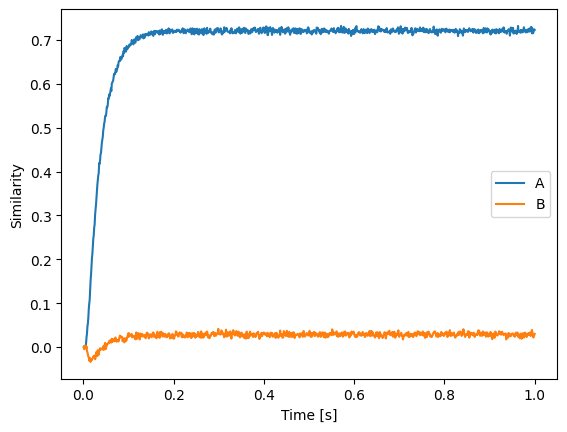

In [5]:
plt.plot(sim.trange(), spa.similarity(sim.data[p], model.vocabs[d]))
plt.xlabel("Time [s]")
plt.ylabel("Similarity")
plt.legend(model.vocabs[d].keys(), loc="best")

There is another detail you might notice here: the `keys` attribute on the vocabularies
is now a function. This is to have `Vocabulary` adhere to the usual Python API of
dictionaries and mapping types.

## Transcode

In the previous example, input was provided directly in the action rules. But this does
not allow for time-varying inputs. The legacy SPA `Input` has been replaced with
`spa.Transcode` which has an API more similar to classic `nengo.Nodes`. It takes either
a constant value or a function which may return any of the following:

* A string that is parsed as a semantic pointer.
* A symbolic Semantic Pointer expression.
* A `SemanticPointer` instance.
* A NumPy array.

The next examples demonstrates this. It also manually specifies a vocabulary, but ignore
this for now as the changes to `Vocabulay` will be discussed later.

In [6]:
vocab = spa.Vocabulary(d, strict=False, pointer_gen=rng)


def stimulus_fn(t):
    if t < 0.5:
        return "A * B"  # Return string to be parsed
    elif t < 1.0:
        return vocab.parse("C * B")  # Return SemanticPointer instance
    else:
        return np.zeros(d)  # Return a numpy array


with spa.Network(seed=0) as model:
    state = spa.State(vocab)
    bind = spa.Bind(vocab)
    spa_input = spa.Transcode(stimulus_fn, output_vocab=vocab)

    spa_input >> state
    state >> bind.input_left
    ~spa.sym.B >> bind.input_right

    p = nengo.Probe(bind.output, synapse=0.03)

In [7]:
with nengo.Simulator(model) as sim:
    sim.run(1.5)

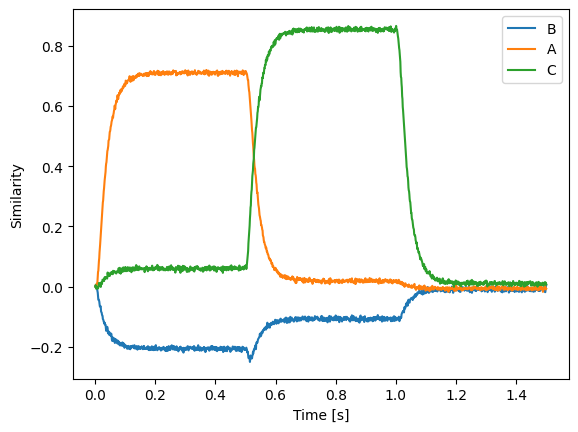

In [8]:
plt.plot(sim.trange(), spa.similarity(sim.data[p], vocab))
plt.xlabel("Time [s]")
plt.ylabel("Similarity")
plt.legend(vocab.keys(), loc="best")

 In addition to providing output, you can now use the `spa.Transcode` module to provide
an input from the network. Its output function gets three inputs: the current simulation
time, a `SemanticPointer` instance of the input, and the input vocabulary. To create a
`Transcode` instance, the dimensionality (or vocabulary) has to be passed in twice. The
first specifies the input vocabulary (the one passed to the output function), the second
one specifies the output vocabulary that will be used to parse the function's output.

In the following example we compute the circular convolution with `~B` in math instead
of a neural network.

In [9]:
def cconv(t, pointer):
    return pointer.vocab.parse("~B") * pointer


with spa.Network(seed=0) as model:
    state = spa.State(d)
    bind = spa.Transcode(cconv, d, d)
    spa_input = spa.Transcode("A * B", output_vocab=d)

    spa_input >> state
    state >> bind

    p = nengo.Probe(bind.output, synapse=0.03)

In [10]:
with nengo.Simulator(model) as sim:
    sim.run(1.0)

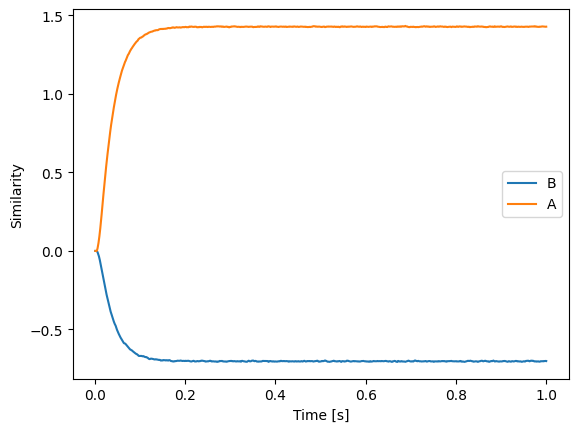

In [11]:
plt.plot(sim.trange(), spa.similarity(sim.data[p], model.vocabs[d]))
plt.xlabel("Time [s]")
plt.ylabel("Similarity")
plt.legend(model.vocabs[d].keys(), loc="best")

## Action rules

We have already seen how to create cortical action rules with nengo_spa. The next
example shows how to add action rules implemented through the basal ganglia-thalamus
loop. It is the classical routing through a sequence example.

The action rules have to be defined in the context of a `spa.ActionSelection` object
(you are allowed to have multiple independent `ActionSelection` objects). Each rule is
defined with the `spa.ifmax` function. The first argument is an expression that provides
the utility value, and all remaining arguments are routings to do when that rules
utility value is the largest.

In [12]:
def start(t):
    if t < 0.05:
        return "A"
    else:
        return "0"


with spa.Network(seed=0) as model:
    state = spa.State(d)
    spa_input = spa.Transcode(start, output_vocab=d)

    spa_input >> state
    with spa.ActionSelection():
        spa.ifmax(spa.dot(state, spa.sym.A), spa.sym.B >> state)
        spa.ifmax(spa.dot(state, spa.sym.B), spa.sym.C >> state)
        spa.ifmax(spa.dot(state, spa.sym.C), spa.sym.D >> state)
        spa.ifmax(spa.dot(state, spa.sym.D), spa.sym.E >> state)
        spa.ifmax(spa.dot(state, spa.sym.E), spa.sym.A >> state)

    p = nengo.Probe(state.output, synapse=0.01)

In [13]:
with nengo.Simulator(model) as sim:
    sim.run(0.5)

Text(0, 0.5, 'Similarity')

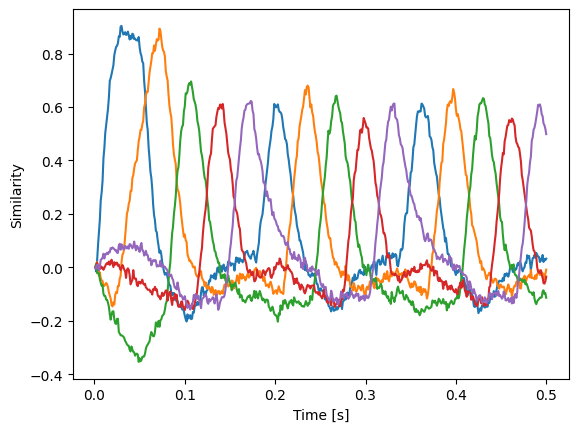

In [14]:
plt.plot(sim.trange(), spa.similarity(sim.data[p], model.vocabs[d]))
plt.xlabel("Time [s]")
plt.ylabel("Similarity")

There is no need to manually create the basal ganglia and thalamus anymore. This happens
automatically. You can access these objects as the `bg` and `thalamus` attributes of the
`ActionSelection` object. This example also demonstrates how to name actions by using a
optional first (!) argument to `ifmax`.

In [15]:
def start2(t):
    if t < 0.05:
        return "A"
    else:
        return "0"


with spa.Network(seed=0) as model:
    state = spa.State(d)
    spa_input = spa.Transcode(start2, output_vocab=d)

    spa_input >> state
    with spa.ActionSelection() as action_sel:
        spa.ifmax("state == A", spa.dot(state, spa.sym.A), spa.sym.B >> state)
        spa.ifmax("state == B", spa.dot(state, spa.sym.B), spa.sym.C >> state)
        spa.ifmax("state == C", spa.dot(state, spa.sym.C), spa.sym.D >> state)
        spa.ifmax("state == D", spa.dot(state, spa.sym.D), spa.sym.E >> state)
        spa.ifmax("state == E", spa.dot(state, spa.sym.E), spa.sym.A >> state)

    p_thalamus = nengo.Probe(action_sel.thalamus.output, synapse=0.01)
    p_utility = nengo.Probe(action_sel.bg.input, synapse=0.01)

In [16]:
with nengo.Simulator(model) as sim:
    sim.run(0.5)

Text(0, 0.5, 'Utility')

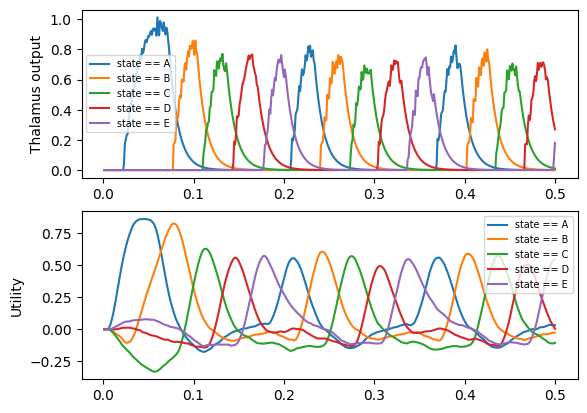

In [17]:
plt.subplot(2, 1, 1)
plt.plot(sim.trange(), sim.data[p_thalamus])
plt.legend(action_sel.keys(), fontsize="x-small")
plt.ylabel("Thalamus output")

plt.subplot(2, 1, 2)
plt.plot(sim.trange(), sim.data[p_utility])
plt.legend(action_sel.keys(), fontsize="x-small")
plt.ylabel("Utility")

Opposed to the legacy SPA, nengo_spa allows arbitrarily complex actions rules. In the
following example we define dot products between two states and dynamic circular
convolutions. All required networks will be created automatically.

In [18]:
with spa.Network(seed=0) as model:
    state_ab = spa.State(d)
    state_a = spa.State(d)
    state_b = spa.State(d)
    out = spa.State(d)

    spa.sym.A * spa.sym.B >> state_ab
    spa.sym.A >> state_a
    state_ab * ~state_a >> state_b

    with spa.ActionSelection():
        spa.ifmax(spa.dot(state_ab, state_a * state_b), state_ab * ~spa.sym.B >> out)
        spa.ifmax(0.5, spa.sym.C >> out)

    p = nengo.Probe(out.output, synapse=0.01)

In [19]:
with nengo.Simulator(model) as sim:
    sim.run(0.5)

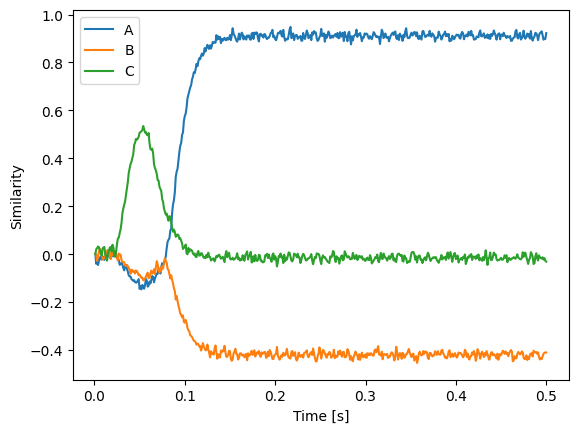

In [20]:
plt.plot(sim.trange(), spa.similarity(sim.data[p], model.vocabs[d]))
plt.xlabel("Time [s]")
plt.ylabel("Similarity")
plt.legend(model.vocabs[d].keys())

Note that there is no automatic sharing of networks in the action rules. If, for
example, you define the same circular convolution in there, two such networks will be
created. But you can define a single circular convolution, assign it to a variable, and
reuse that variable to reuse the circular convolution network like so:

```python
cconv = state1 * state2
cconv * ~POINTER1 >> state3
cconv * ~POINTER2 >> state4
```

If you have nengo_gui installed, it can be used to take a look at all the things that
get created.

In [21]:
try:
    from nengo_gui.ipython import IPythonViz

    vis = IPythonViz(model)
except (ImportError, AttributeError):
    print("GUI not installed or code not executed in Jupyter notebook.")
    vis = None
vis

GUI not installed or code not executed in Jupyter notebook.


## Vocabularies

Nengo_spa behaves a lot like legacy SPA when providing dimensionalities only.
Vocabularies will implicitly be created according to the specified dimensions and
Semantic Pointers will be automatically added. When creating a vocabulary explicitly,
things are a little bit different. In that case the vocabulary will be in strict-mode by
default. That means an exception will be raised when trying to parse a Semantic Pointer
that is not in the vocabulary. This is to prevent accidentally adding new Semantic
Pointers (something that tended to happen with the associative memory in legacy SPA) and
can make it easier to notice typing errors.

In [22]:
vocab = spa.Vocabulary(d, pointer_gen=rng)
try:
    vocab.parse("A")
except SpaParseError as err:
    print(err)

Error parsing expression 'A' with 32-dimensional vocab  at 0x7f7c467e3e20: name 'A' is not defined


All Semantic Pointers have to be added to the vocabulary with either `add` or the new
`populate` method before they are recognized by `parse`. You can add multiple pointers
add once by separating them with a semicolon in `populate`.

In [23]:
vocab = spa.Vocabulary(d, pointer_gen=rng)
vocab.add("A", vocab.create_pointer())
vocab.populate("B; C")
vocab.parse("A + B + C")

SemanticPointer(array([ 3.05703289e-02,  5.17268764e-01, -3.05163733e-02, -1.65742905e-01,
        4.07998650e-04, -4.66466802e-01,  1.85889223e-01, -9.84536190e-02,
        2.05388329e-01,  6.66899980e-01, -1.31254620e-01, -3.40330950e-02,
        2.41410023e-01, -5.17499157e-01, -2.38508011e-01,  2.88028693e-01,
        2.79172931e-02,  4.23138182e-01, -1.77870802e-01, -5.20428358e-01,
       -3.18948002e-01,  2.50932866e-01,  2.45376879e-01,  2.72511956e-01,
        3.70793384e-01, -4.11998873e-01,  5.07650926e-01,  3.00410895e-01,
       -3.06841313e-01,  3.36849637e-01, -6.91286211e-02, -2.82017544e-01]), vocab=<nengo_spa.vocabulary.Vocabulary object at 0x7f7c50fcdd90>, algebra=<nengo_spa.algebras.hrr_algebra.HrrAlgebra object at 0x7f7c53f6b550>, name='A + B + C'

If you prefer to automatically add unknown vectors, you can disable strict mode. This
can be especially useful when experimenting with initial ideas in the GUI.

In [24]:
vocab = spa.Vocabulary(d, strict=False, pointer_gen=rng)
vocab.parse("A")

SemanticPointer(array([-0.02289058, -0.13421333,  0.04758596, -0.13906621,  0.10455379,
        0.16095464, -0.11882202,  0.20077817, -0.04005542,  0.19448251,
        0.07376143,  0.18893406, -0.16783948, -0.01797782,  0.2443353 ,
       -0.10404104, -0.34294483, -0.32701773, -0.42193715, -0.35590082,
       -0.06929582,  0.21522891, -0.07444539,  0.05446297, -0.0185161 ,
        0.00143914, -0.02831479, -0.02932172,  0.0776329 , -0.1979663 ,
        0.17004599,  0.15487689]), vocab=<nengo_spa.vocabulary.Vocabulary object at 0x7f7c50ff8d30>, algebra=<nengo_spa.algebras.hrr_algebra.HrrAlgebra object at 0x7f7c53f6b550>, name='A'

The new `populate` method is much more powerful than adding pointers with `parse`. For
example you can use existing Semantic pointers to construct new ones and you can use
transforms as `normalized()` and `unitary()` to make vectors unit length or normalized.
Note that a simple Semantic Pointer will be normalized, but you need to explicitly do
this when constructing a pointer out of others.

In the following example we create a vocabulary with four pointers *A*, *B*, *C*, and
*D*. *A* is made unitary, D is constructed from other vectors and normalized.

In [25]:
vocab = spa.Vocabulary(d)
vocab.populate("A.unitary(); B; C; D = (A * B + C).normalized()")

Another new and sometimes useful method is `parse_n` which allows to parse multiple
Semantic Pointer expressions at once. This can be useful for programmatically
constructing a list of pointers for plotting. The following example demonstrates that
for all convolution pairs. It also shows that when using a predefined vocabulary, the
modules will obtain their dimensionality from that vocabulary. No need to pass
dimensionality and vocabulary anymore!

In [26]:
vocab = spa.Vocabulary(d, pointer_gen=rng)
vocab.populate("A; B; C")

with spa.Network() as model:
    state = spa.State(vocab)
    spa.sym.A * spa.sym.B >> state
    p = nengo.Probe(state.output, synapse=0.01)

In [27]:
with nengo.Simulator(model) as sim:
    sim.run(0.5)

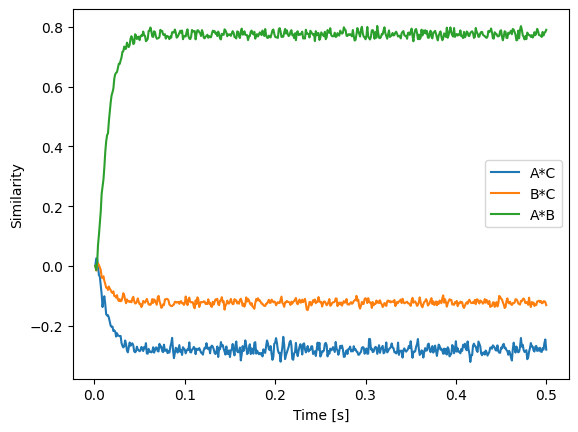

In [28]:
plot_keys = pairs(vocab)
plot_vectors = vocab.parse_n(*plot_keys)

plt.plot(sim.trange(), spa.similarity(sim.data[p], plot_vectors))
plt.xlabel("Time [s]")
plt.ylabel("Similarity")
plt.legend(plot_keys)

Another feature of nengo_spa is “type-safety” in the sense that you cannot just connect
things with different vocabularies in action rules.

In [29]:
v1 = spa.Vocabulary(d)
v1.populate("A; B")
v2 = spa.Vocabulary(d)
v2.populate("B; C")

try:
    with spa.Network() as model:
        state1 = spa.State(v1)
        state2 = spa.State(v2)
        state2 >> state1
except SpaTypeError as err:
    print(err)

Different vocabularies: TVocabulary<32-dimensional vocab  at 0x7f7c518da0a0>, TVocabulary<32-dimensional vocab  at 0x7f7c45b7d970>


If we want to do this, we have to be explicit about how the conversion between the
vocabularies is supposed to be happen. The first option (if both vocabularies have the
same dimensionality) is to just reinterpret the Semantic Pointer in the other
vocabulary. Because the vectors in both vocabularies are independent (by default) the
*A* from `v2` will be different from *A* in `v1`.

In [30]:
v1 = spa.Vocabulary(d, pointer_gen=rng)
v1.populate("A; B")
v2 = spa.Vocabulary(d, pointer_gen=rng)
v2.populate("A; B")

with spa.Network() as model:
    state1 = spa.State(v1)
    state2 = spa.State(v2)

    spa.reinterpret(state2) >> state1
    spa.sym.A >> state2

    p = nengo.Probe(state1.output, synapse=0.01)

In [31]:
with nengo.Simulator(model) as sim:
    sim.run(0.5)

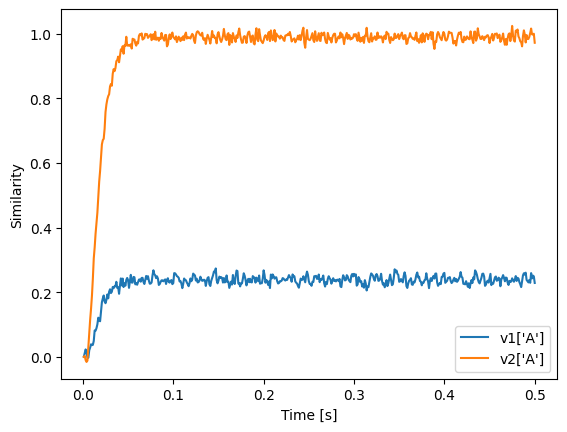

In [32]:
plt.plot(sim.trange(), v1["A"].dot(sim.data[p].T))
plt.plot(sim.trange(), v2["A"].dot(sim.data[p].T))
plt.xlabel("Time [s]")
plt.ylabel("Similarity")
plt.legend(["v1['A']", "v2['A']"])

We see that the value in `state2` is still similar to `v2`'s *A* even though `state2`
uses `v1` as vocabulary.

The second choice to convert between vocabularies is `translate` which will construct a
transformation matrix to convert from one vocabulary to the other based on the Semantic
Pointer names. This also works with vocabularies that do not match in dimensionality,
but the target vocabulary should contain all keys of the source vocabulary. If this is
not the case, you will get either a warning or an exception depending on whether you are
using strict-mode vocabularies. You can also use the `populate=True` argument to
`translate` to have all missing keys added to the target vocabulary.

In [33]:
v1 = spa.Vocabulary(d, pointer_gen=rng)
v1.populate("A; B")
v2 = spa.Vocabulary(d, pointer_gen=rng)
v2.populate("A; B")

with spa.Network() as model:
    state1 = spa.State(v1)
    state2 = spa.State(v2)

    spa.translate(state2, v1) >> state1
    spa.sym.A >> state2

    p = nengo.Probe(state1.output, synapse=0.01)

In [34]:
with nengo.Simulator(model) as sim:
    sim.run(0.5)

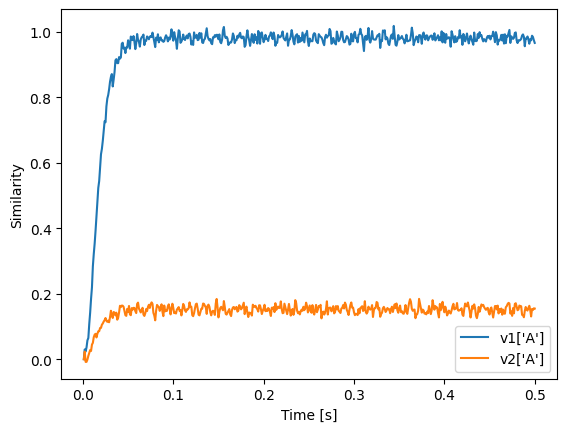

In [35]:
plt.plot(sim.trange(), v1["A"].dot(sim.data[p].T))
plt.plot(sim.trange(), v2["A"].dot(sim.data[p].T))
plt.xlabel("Time [s]")
plt.ylabel("Similarity")
plt.legend(["v1['A']", "v2['A']"])

## nengo_spa and the config system

One of the major improvements in nengo_spa is the extensive use of Nengo's config
system. For example it allows to set the vocab for all states globally.

In [36]:
with spa.Network() as model:
    model.config[spa.State].vocab = d

    state1 = spa.State()
    state2 = spa.State()

    state1 >> state2
    spa.sym.A >> state1

    p = nengo.Probe(state2.output, synapse=0.01)

In [37]:
with nengo.Simulator(model) as sim:
    sim.run(0.5)

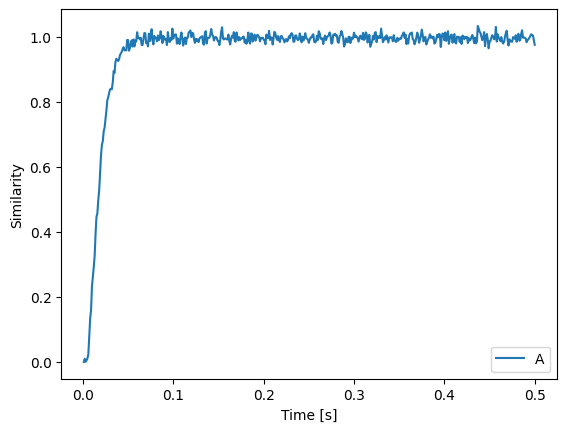

In [38]:
plt.plot(sim.trange(), spa.similarity(sim.data[p], model.vocabs[d]))
plt.xlabel("Time [s]")
plt.ylabel("Similarity")
plt.legend(model.vocabs[d].keys())

The config system can also be used to set neuron numbers, subdimensions, and various
other parameters, in particular of objects created when building action rules.

In [39]:
def start3(t):
    if t < 0.1:
        return "A"
    else:
        return "0"


with spa.Network(seed=0) as model:
    model.config[spa.State].neurons_per_dimension = 10
    model.config[spa.State].subdimensions = 1
    model.config[spa.Thalamus].synapse_channel = nengo.Lowpass(0.1)

    state = spa.State(d)
    spa_input = spa.Transcode(start3, output_vocab=d)

    spa_input >> state
    with spa.ActionSelection():
        spa.ifmax(spa.dot(state, spa.sym.A), 2 * spa.sym.B >> state)
        spa.ifmax(spa.dot(state, spa.sym.B), 2 * spa.sym.C >> state)
        spa.ifmax(spa.dot(state, spa.sym.C), 2 * spa.sym.A >> state)

    p = nengo.Probe(state.output, synapse=0.01)

In [40]:
with nengo.Simulator(model) as sim:
    sim.run(0.5)

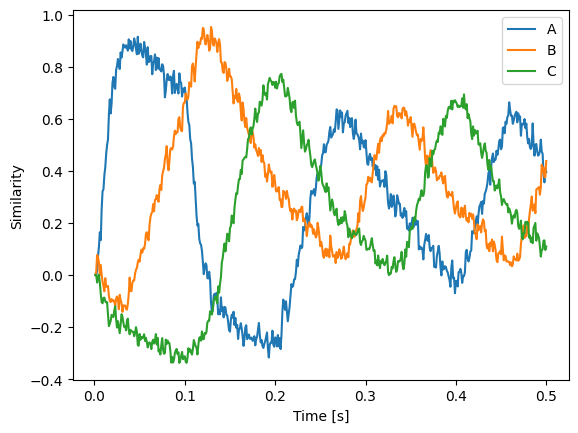

In [41]:
plt.plot(sim.trange(), spa.similarity(sim.data[p], model.vocabs[d]))
plt.xlabel("Time [s]")
plt.ylabel("Similarity")
plt.legend(model.vocabs[d].keys())

## Semantic Pointers

The `SemanticPointer` class has become immutable in nengo_spa to avoid accidental
modifiction of Semantic Pointers. Whenever an operation is applied to a
`SemanticPointer` (for example `SemanticPointer(d) + SemanticPointer(d)` or
`SemanticPointer(d).normalized()` a new instance will be created.

To facilitate mathematical analysis of encoding schemes some special vectors are
predefined:

* `nengo_spa.pointer.Identity(d)` gives the identity vector for circular convolution.
* `nengo_spa.pointer.Zero(d)` gives the vector of all zeros (absorbing element for
  circular convolution).
* `nengo_spa.pointer.AbsorbingElement(d)` gives a vector that destroys all information
  under circular convolution except for a DC offset.

## Representing identity

In nengo_spa `spa.State()` is optimized to allow the representation of the identity
vector. This is not always necessary as in many models the identity never needs to
represented. With `represent_identity=False` this optimization can be disabled. This can
make the representation for non-identity vectors slightly better. It also simplifies the
internal structure of `spa.State()` which can be helpful for applying learning rules.

## New associative memory classes

To reduce the number of arguments of the associative memory class it has been split into
two classes. `spa.ThresholdingAssocMem` is the applying a simple threshold,
`spa.WTAAssocMem` performs a winner-take-all clean-up with lateral inhibitory
connections. There is also a new type of associative memory `spa.IAAssocMem` based on
independent accumulators, that also exhibits winner-take-all behaviour, but with
different dynamics. For more information see the paper "[A Spiking Independent
Accumulator Model for Winner-Take-All
Computation](http://compneuro.uwaterloo.ca/publications/gosmann2017a.html)".

To implement auto-associative memories, the `input_keys` and `output_keys` arguments
have been replaced by a single `mapping` arguments.